In [1]:
import os,sys
import csv
import copy
import math

from IPython.display import Math
from IPython.display import Latex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from clawpack import pyclaw

from scipy.integrate import simps, trapz

sys.path.append("/home/pgrover/Dropbox/PhD/Morphodynamic_Model/pymorph")
from weno import WENO,ENO,get_exact_solution, get_left_flux,get_right_flux
from weno import get_stencil

%matplotlib inline
%load_ext autoreload
%autoreload 2

The following is based on the Gaussian Hump simulation described in Long et al. (2008)

## Analytical Solution

Forthe Gaussian Hump combined with the power function relating the current speed and the transport rate, an analytical solution exists. This will be used to check against the calculated value. See the description in both the Long et al (2008) and the Johnson and Zyserman (2002) papers (see section 4.1 - Hump in a channel).

In [3]:
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Water depth
s= 0.0            # Datum
beta = 0.01

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))

z = np.zeros(nx)
# Eq 66
z = np.array([(-h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()



Grid dx = 1.0


In [6]:
xb_600, zb_600 = get_exact_solution(zc,xc, nP,s,a,b,Q,h0,2000)

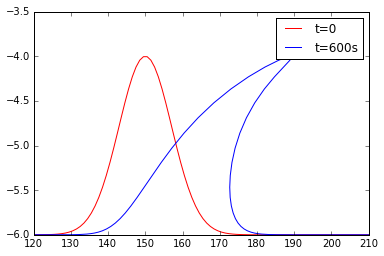

In [7]:
plt.plot(xc,zc,'r',label='t=0')
plt.plot(xb_600,zb_600,label='t=600s')
plt.ylim([-6,-3.5])
plt.xlim([120,210])
plt.legend()

In [64]:
nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))


z = np.zeros(nx)
# Eq 66
z = np.array([(-h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)


Grid dx = 1.0


(120, 210)

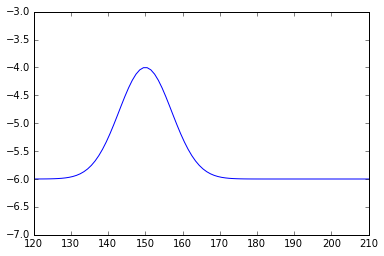

In [65]:
plt.plot(xc,zc)
plt.ylim([-7,-3])
plt.xlim([120,210])

(100, 250)

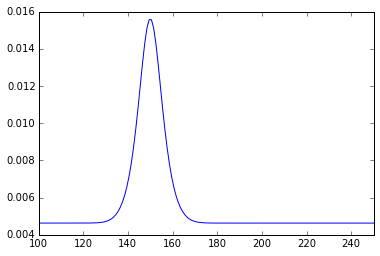

In [66]:
plt.plot(xc,qbedload)
plt.xlim([100,250])

In [9]:
nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))

a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Water depth
s= 0.0            # Datum
beta = 0.01
z = np.zeros(nx)
# Eq 66
z = np.array([(-h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

nt = 6000   # Number of time steps
dt = 0.1 # Time step size (s)

k = 3 # number of weights Order= 2*k-1

c=1

for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2
        xloc = xc[i-(k-1):i+k] #i+k-1-(i-(k-1)-1) = 2k -1 
        
        qloc = get_stencil(qbedload,i-(k-1),i+k)
 
        #f_left,f_right = ENO(xloc,qloc,k)
        f_left,f_right = WENO(xloc,qloc,k)
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        flux[i]=0.5*(c+abs(c))*f_left + 0.5*(c-abs(c))*f_right
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2
        if c>0:
            zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(flux[i]-flux[i-1])
        else:
            zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(flux[i+1]-flux[i])
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b
    

plt.plot(xc,z,'r')
plt.plot(xc,zc)
plt.ylim([-6,-3.5])
plt.xlim([120,210])

Grid dx = 1.0


IndexError: index 5 is out of bounds for axis 0 with size 5

(120, 210)

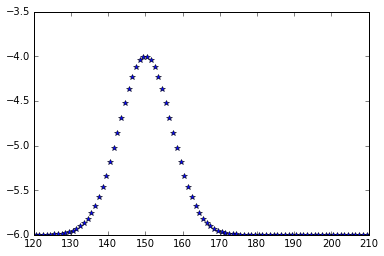

In [10]:
plt.plot(xc,zc,'b*')
plt.ylim([-6,-3.5])
plt.xlim([120,210])

## Attempt 2

Grid dx = 1.0
Grid nx = 300


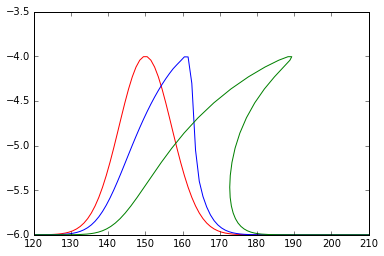

In [11]:
nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Water depth
s= 0.0            # Datum
beta = 0.01
z = np.zeros(nx)
# Eq 66
z = np.array([(-h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

nt = 600   # Number of time steps
dt = 1.0 # Time step size (s)

plt.plot(xc,z,'r')
plt.ylim([-6,-3.5])
plt.xlim([120,210])

cntr = 0

h = s - zc
u = Q/h
qbedload = a*u**b

for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2
        # xloc = xc[i-(k-1):i+k]
        #xloc = get_stencil(xc,i-(k-1),i+k+1) #i+k-1-(i-(k-1)-1) = 2k -1 
        zloc = get_stencil(zn,i-(k-1),i+k+1)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-(k-1),i+k+1)
        if len(qloc)<>6:
            raise ValueError('Stencil is incorrect')
 
        #f_left,f_right = ENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,qloc,k)
        
        
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2
        # This makes the dune travel backwards but looks correct ???
        #zc[i] = zn[i]+(1./(1.-nP))*dt/dx*(flux[i+1]-flux[i])

        # This results in oscillations but the shape is actually correct
        #zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(flux[i+1]-flux[i])
        
        floc = get_stencil(flux,i-1,i+1)

        zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
        
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b

plt.plot(xc,zc)
plt.plot(xb_600,zb_600,label='t=600s')
    





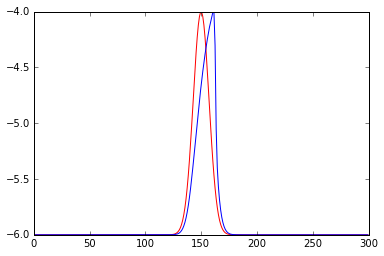

In [112]:
plt.plot(xc,z,'r')


plt.plot(xc,zc)

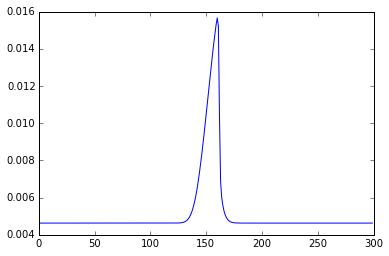

In [113]:
plt.plot(flux)

In [110]:
len(flux)

301

In [28]:
k=3
i=299
xloc = get_stencil(xc,i-(k-1),i+k+1)
print xloc

[ 297.5  298.5  299.5    0.5    1.5    2.5]


In [27]:
k=3
i=0
xloc = get_stencil(xc,i-(k-1),i+k+1)
print xloc

[ 298.5  299.5    0.5    1.5    2.5    3.5]


In [29]:
len(xc)

300